In [1]:
# File I/O
import os
import shutil

# Frame handling
import numpy as np
import cv2

# PyTorch and model training
import torch
from torchvision.io import read_video
import torchvision.transforms as transforms
from torchvision.models.optical_flow import raft_large, Raft_Large_Weights
from torchvision.utils import flow_to_image
import random

# Visualization
from matplotlib import pyplot as plt

# Human Motion Database 51 (HMDB51) Optical Flow Extraction

### Define constants and set seed

In [2]:
# Optical flow frames (total is FRAME_SELECT_COUNT x 2 + 1 middle frame)
FRAME_SPLIT_COUNT = 8  # Frames before and after middle frame to split video halves into
FRAME_SELECT_COUNT = (FRAME_SPLIT_COUNT) // 2  # Subset of frames to select from splits before and after middle frame
IMAGE_SIZE = (224, 224)
DEVICE = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Device: {DEVICE}")

# Seed
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

Device: cuda


### Load train, validation, and test splits

In [3]:
def input_list_from_file(file_path):
    list = []
    with open(file_path, "r") as f:
        for item in f:
            list.append(item.strip())
    return list

In [4]:
# Input training and validation set
train_val_files = input_list_from_file(os.path.join("HMDB51", "train_val_files.txt"))
train_val_labels = input_list_from_file(os.path.join("HMDB51", "train_val_labels.txt"))

# Input test set
test_files = input_list_from_file(os.path.join("HMDB51", "test_files.txt"))
test_labels = input_list_from_file(os.path.join("HMDB51", "test_labels.txt"))

# Combine sets
all_files = train_val_files + test_files
all_labels = train_val_labels + test_labels

### Extract frames around the middle frame from videos, calculate optical flow between them using RAFT, and visualize results from a video

In [5]:
def get_video_frame_count(file_path, fast_method=False):
    # Check that video can be loaded
    cap = cv2.VideoCapture(file_path)
    if not cap.isOpened():
        return None

    # Fast but sometimes inaccurate frame count
    if fast_method:
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # Accurate frame count
    else:
        # Loop until all video frames are processed
        frame_count = 0
        while True:
            # Read video frame
            ret, ret_frame = cap.read()
            # Video end
            if not ret:
                break
            frame_count += 1
        cap.release()

    return frame_count

In [6]:
def plot_images(imgs, col_titles=None):
    # Turn row to 2D grid
    if not isinstance(imgs[0], list):
        imgs = [imgs]
    
    _, axs = plt.subplots(nrows=len(imgs), ncols=len(imgs[0]), squeeze=False, figsize=(8, 16))
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = transforms.functional.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img))
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            if col_titles and row_idx == 0:
                ax.set_title(col_titles[col_idx])
    
    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

In [7]:
class SquarePadTensor:
    def __call__(self, img):
        max_size = max(img.size(-2), img.size(-1))

        pad_left = (max_size - img.size(-1)) // 2
        pad_top = (max_size - img.size(-2)) // 2

        # Account for odd sizes
        pad_right = max_size - (img.size(-1) + pad_left)
        pad_bottom = max_size - (img.size(-2) + pad_top)

        return transforms.functional.pad(img, (pad_left, pad_top, pad_right, pad_bottom), 0, "constant")

In [8]:
def get_video_optical_flow(file_path, frames_idx, device="cpu", plot_results=False):
    """
    Computes optical flow from frame pairs using RAFT.

    :param file_path: path to load video frames from
    :param frames_idx: selected frames to pair consecutively for optical flow computation
    :param device: device choice
    :param plot_results: plots optical flow results if True

    :return: returns optical flow RGB numpy arrays
    """
    frames, _, _ = read_video(str(video_path), output_format="TCHW", pts_unit="sec")

    # Create frame pair batches
    frame1_batch_idx = frames_idx[:-1]
    frame2_batch_idx = frames_idx[1:]
    frame1_batch = torch.stack([frames[idx] for idx in frame1_batch_idx])
    frame2_batch = torch.stack([frames[idx] for idx in frame2_batch_idx])

    # Transforms
    size_transforms = transforms.Compose([
        SquarePadTensor(),
        transforms.Resize(IMAGE_SIZE),
    ])
    weights = Raft_Large_Weights.DEFAULT
    weights_transforms = weights.transforms()

    # Apply transforms
    frame1_batch = size_transforms(frame1_batch)
    frame2_batch = size_transforms(frame2_batch)
    # Rescale to [-1, 1]
    frame1_batch_rescaled, frame2_batch_rescaled = weights_transforms(frame1_batch, frame2_batch)

    # Run RAFT model
    model = raft_large(weights=weights).to(device)
    model = model.eval()
    # Get last iteration results
    optical_flows = model(frame1_batch_rescaled.to(device), frame2_batch_rescaled.to(device))[-1]
    # Convert optical flow to RGB
    optical_flows_rgb = flow_to_image(optical_flows)

    if plot_results:
        plot_images([[frame1, frame2, optical_flow] for (frame1, frame2, optical_flow) in zip(frame1_batch, frame2_batch, optical_flows_rgb)],
                   col_titles=["First frame", "Second frame", "Optical flow"])

    # Convert tensor to numpy arrays
    optical_flows_rgb = optical_flows_rgb.cpu().numpy()
    optical_flows_rgb = [optical_flow.transpose(1, 2, 0) for optical_flow in optical_flows_rgb]

    return optical_flows_rgb

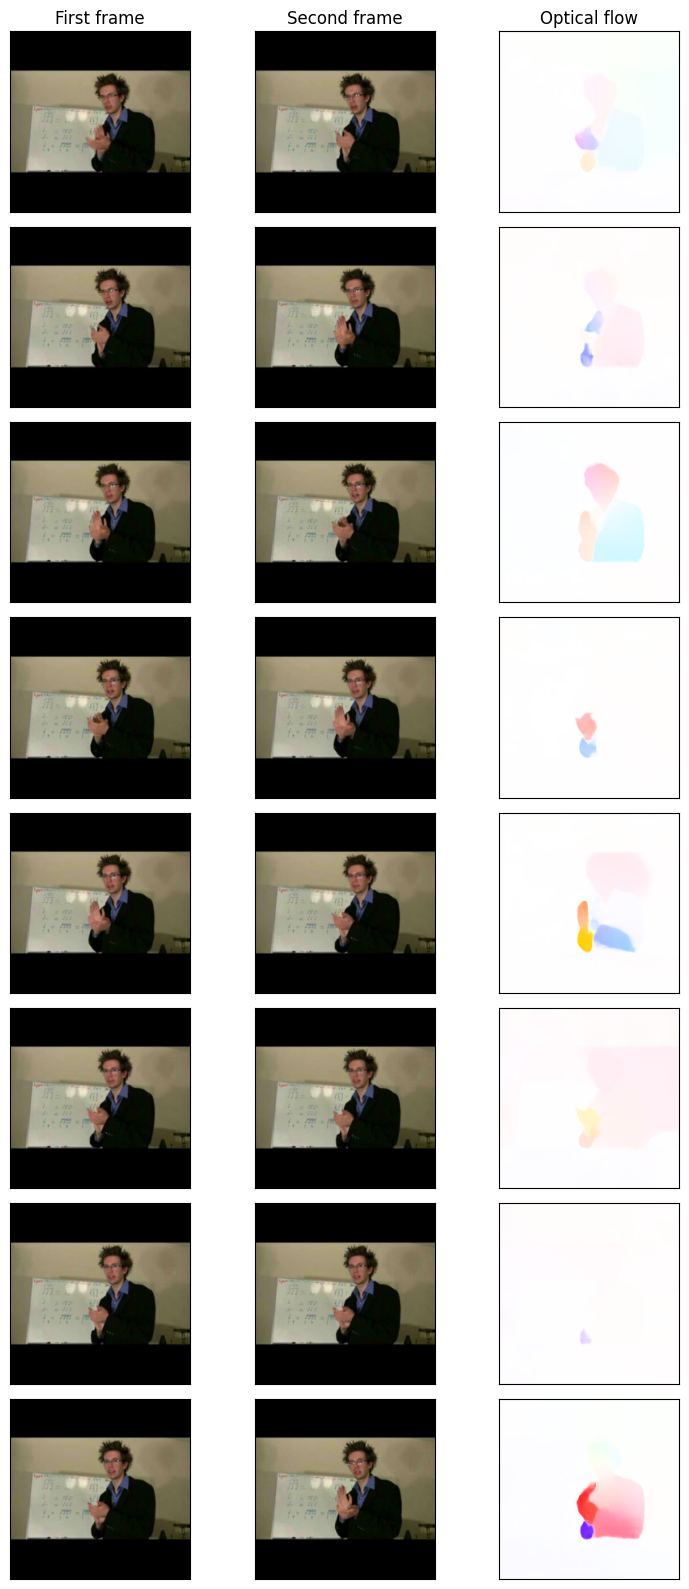

In [9]:
output_path = os.path.join("HMDB51", "optical_flow_data")
if os.path.exists(output_path):
    shutil.rmtree(output_path)

action_categories = {"clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse",
        "run", "shoot_bow", "smoke", "throw", "wave"}

plot_results = True  # Plot first optical flow results

for file, label in zip(all_files, all_labels):
    # Get middle frame
    video_path = os.path.join("HMDB51", "video_data", label, file)
    frame_count = get_video_frame_count(video_path, fast_method=False)
    middle_frame = frame_count // 2

    # Select frames before and after middle frame
    frames_before_middle = list(np.linspace(start=0, stop=middle_frame, num=FRAME_SPLIT_COUNT + 1, dtype=int))[:-1]
    frames_after_middle = list(np.linspace(start=middle_frame, stop=frame_count-1, num=FRAME_SPLIT_COUNT + 1, dtype=int))[1:]
    frames_before_middle_count = min(FRAME_SELECT_COUNT, len(frames_before_middle))
    frames_after_middle_count = min(FRAME_SELECT_COUNT, len(frames_after_middle))
    frames_before_middle = frames_before_middle[-frames_before_middle_count:]
    frames_after_middle = frames_after_middle[:frames_after_middle_count]
    # Combine frames before middle frame, middle frame, and frames after middle frame
    frames_idx = frames_before_middle + [middle_frame] + frames_after_middle

    # Get optical flow
    optical_flows = get_video_optical_flow(video_path, frames_idx, DEVICE, plot_results)
    plot_results = False

    # Save optical flow
    folder_name = os.path.join(output_path, label)
    os.makedirs(folder_name, exist_ok=True)
    file_split = file.split(".")[0]
    for idx, optical_flow in enumerate(optical_flows):
        optical_flow = cv2.cvtColor(optical_flow, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(folder_name, file_split + "_" + str(idx) + ".png"), optical_flow)